### Итоговое задание по Проекту 4. Компьютер говорит «Нет» 

#### Для каждого client_id в наборе тестов мы должны предсказать вероятность для default переменной.
#### где client_id - идентификатор заемщика, default - вероятность дефолта по кредиту.
### Метрика качества
Результаты оцениваются по площади под кривой ROC AUC

---

## 1. Импорт библиотек

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
import seaborn as sns 

import warnings
from collections import Counter
from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from math import log as log

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [68]:
# зафиксируем версию пакетов и RANDOM_SEED, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 42

## 2. Импорт данных

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
# Определим кол-во строк и столбцов тренировочного и тестового датасетов проекта
print('Тренировочный датасет проекта содержит {} строк, {} столбцов\n'.format(df_train.shape[0], df_train.shape[1]))
print('Тестовый датасет проекта содержит {} строк, {} столбцов\n'.format(df_test.shape[0], df_test.shape[1]))

Тренировочный датасет проекта содержит 73799 строк, 19 столбцов

Тестовый датасет проекта содержит 36349 строк, 18 столбцов



In [5]:
#Заранее сохраняем значения client_id для предсказания тестовой выборки
id_test = df_test['client_id']

In [6]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, поэтому оставим как есть

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## 3. Предварительный анализ данных


Подробнее по признакам:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

In [7]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,NaN
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,NaN


In [8]:
# Определим общее кол-во строк и столбцов объединенного датасета проекта
print('Объединенный датасет проекта содержит {} строк, {} столбцов\n'.format(df.shape[0], df.shape[1]))

Объединенный датасет проекта содержит 110148 строк, 20 столбцов



In [9]:
# Подсчитаем количество столбцов по типам данных
print(df.dtypes.value_counts())

int64      12
object      6
float64     2
dtype: int64


In [47]:
# Определим кол-во столбцов, содержащих пустые значения
print(f'В {df.isnull().any().sum()} столбцах есть отсутствующие значения.\n')

# Посмотрим абс и относит величину пропущенных значений по каждому признаку
cols_isnan=pd.DataFrame({'count': df.isnull().sum(),
                              'ratio': df.isnull().sum()/len(df)}).query('count > 0')
print('Признаки, в которых есть данные с пропущенными значениями\n\n{}'
      .format(cols_isnan))

В 2 столбцах есть отсутствующие значения.

Признаки, в которых есть данные с пропущенными значениями

           count     ratio
education    478  0.004340
default    36349  0.330001


In [48]:
# Посмотрим, какие значения есть в признаке Образование:
df.education.value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

In [49]:
# Заполним пропуски в образовании самым распространенным значением SCH
df.education.fillna('SCH', inplace=True)
# И проверим, что получилось:
df.education.value_counts(dropna=False)

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [10]:
# Распределим признаки (за исключением client_id, default и sample) по категориям: бинарные, категориальные и числовые
cols = df.columns[1:-2]

#cols_type = {'binary':, 'category':, 'numeric':}
binary_cols = []
category_cols = []
numeric_cols = []
for j in cols:
    if len(df[j].value_counts(dropna=False))==2:
        binary_cols.append(j)
    elif len(df[j].value_counts(dropna=False))<11 or df[j].dtypes==object:
        category_cols.append(j)
    #elif df[j].dtypes==float:
    else:
        numeric_cols.append(j)

print('binary_columns =', binary_cols, '\ncategory_columns =', category_cols, '\nnumeric_columns =', numeric_cols)

binary_columns = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] 
category_columns = ['app_date', 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'] 
numeric_columns = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


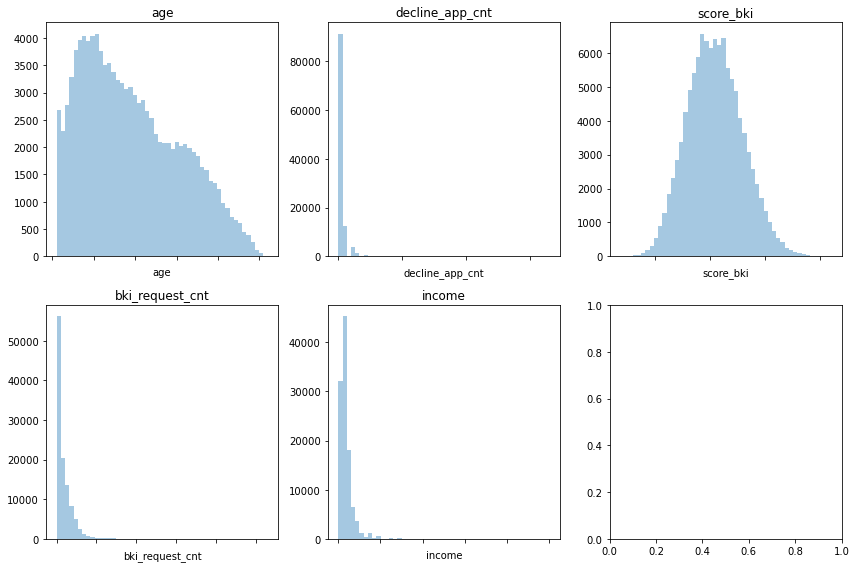

In [19]:
# Посмотрим на распределение числовых данных:
fig, axes = plt.subplots(nrows=2, ncols=(round(len(numeric_cols)/2)+1), figsize=(12, 8))
i = 0

for j in numeric_cols:
    plot = sns.distplot(df[j], kde=False, ax=axes.flatten()[i])
    plot.set_title(j)
    plot.set_xticklabels([])
    plt.tight_layout()
    i = i + 1


После построения гистограмм видно, что кроме score_bki распределения числовых переменных имеют тяжёлый правый хвост.

Чтобы сделать распределение данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям в суммах у линейных моделей.

Прологарифмируем и построим графики распределения логарифмированных переменных.

In [14]:
# Для начала создам функцию по созданию нового признака:


def creating_new_columns(df, column, function):
    if function == 'log':
        df[df[column].name+'_log'] = np.log(df[column][df[column] > 0])
        df[df[column].name+'_log'].fillna(0, inplace=True)
    elif function=='sqrt':
        df[df[column].name+'_sqrt'] = np.sqrt(df[column][df[column] > 0])
        df[df[column].name+'_sqrt'].fillna(0, inplace=True)
    elif function =='isNAN':
        if df[column].isnull().any() == True:
            df[df[column].name+'_isNAN'] = pd.isna(df[column]).astype('uint8')

In [15]:
# Для каждого числового признака создам новый признак, содержащий логарифмированную величину этой переменной

numeric_log = []
func = 'log'

for i in numeric_cols:
    creating_new_columns(df, i, func)
    numeric_log.append(i+'_'+func)
    
df[numeric_cols+numeric_log].head(10)

,age,decline_app_cnt,score_bki,bki_request_cnt,income,age_log,decline_app_cnt_log,score_bki_log,bki_request_cnt_log,income_log
0,29,0,-2.271884,3,50000,3.367296,0.000000,0.0,1.098612,10.819778
1,39,5,-1.504999,2,5000,3.663562,1.609438,0.0,0.693147,8.517193
2,50,0,-1.691339,1,30000,3.912023,0.000000,0.0,0.000000,10.308953
3,56,0,-2.374182,1,17000,4.025352,0.000000,0.0,0.000000,9.740969
4,38,0,-2.487502,0,120000,3.637586,0.000000,0.0,0.000000,11.695247
5,55,0,-1.740224,7,30000,4.007333,0.000000,0.0,1.945910,10.308953
6,30,3,-1.387847,5,11000,3.401197,1.098612,0.0,1.609438,9.305651
7,41,0,-3.066047,3,80000,3.713572,0.000000,0.0,1.098612,11.289782
8,34,0,-3.117086,0,5000,3.526361,0.000000,0.0,0.000000,8.517193
9,28,0,-2.185172,0,80000,3.332205,0.000000,0.0,0.000000,11.289782


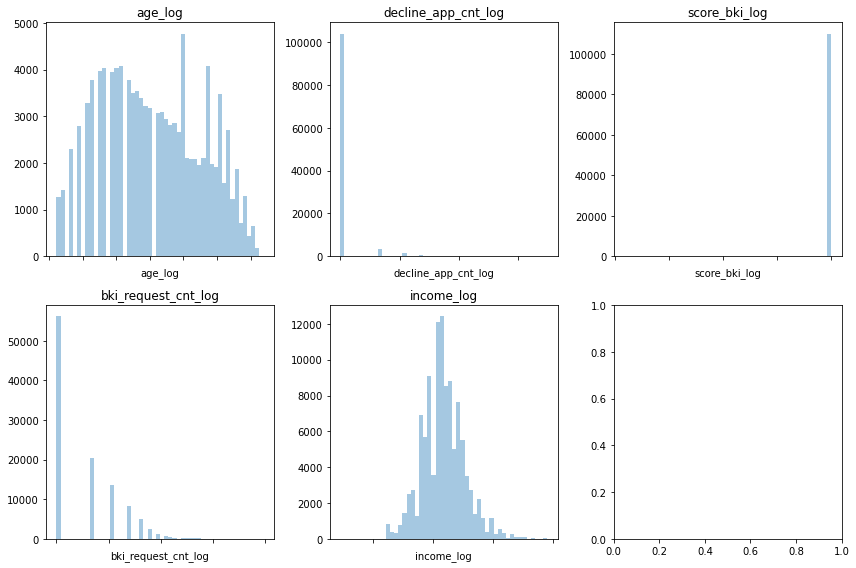

In [18]:
# Посмотрим распределение логарифмов
fig, axes = plt.subplots(nrows=2, ncols=(round(len(numeric_log)/2)+1), figsize=(12, 8))
i = 0

for j in numeric_log:
    plot = sns.distplot(df[j], kde=False, ax=axes.flatten()[i])
    plot.set_title(j)
    plot.set_xticklabels([])
    plt.tight_layout()
    i = i + 1


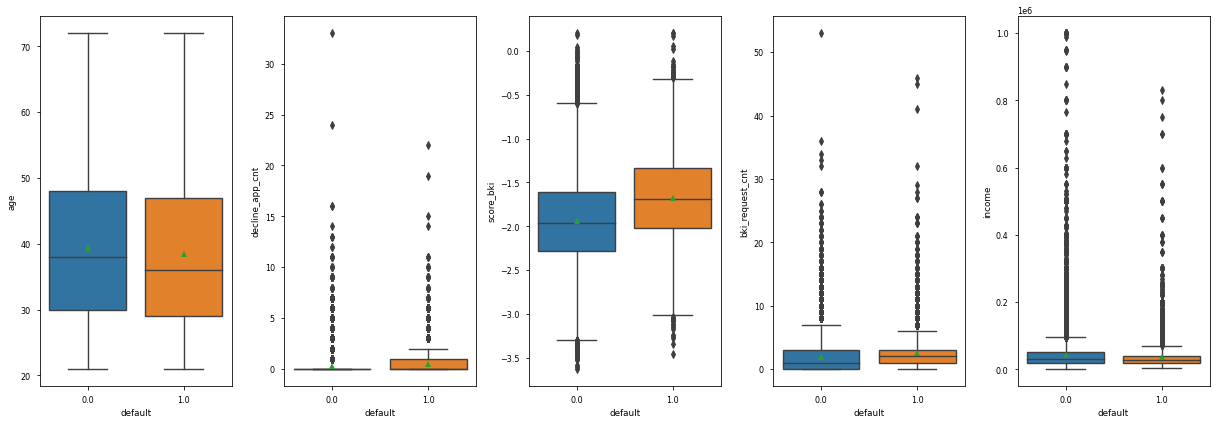

In [51]:
# Построим боксплоты для числовых переменных
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_cols), figsize=(17, 6))
i = 0

for j in numeric_cols:
    sns.boxplot( y=df[j], x=df["default"], showmeans=True, ax=axes.flatten()[i]);
    plt.tight_layout()#plt.show()
    i = i+1

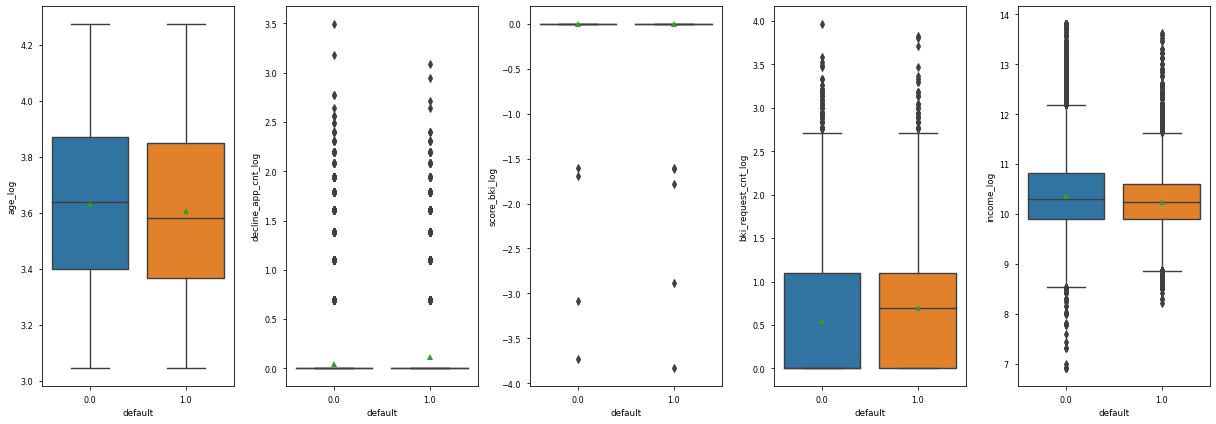

In [52]:
# Построим боксплоты для логарифмированных переменных
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_log), figsize=(17, 6))
i = 0

for j in numeric_log:
    sns.boxplot( y=df[j], x=df["default"], showmeans=True, ax=axes.flatten()[i]);
    plt.tight_layout()#plt.show()
    i = i+1

Видно, что кроме признака Age, во всех других признаках очень много выбросов. Но их пока трогать не буду.

In [23]:
# Преобразуем формат признака даты
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,age_log,decline_app_cnt_log,score_bki_log,bki_request_cnt_log,income_log
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN,3.367296,0.000000,0.0,1.098612,10.819778
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN,3.663562,1.609438,0.0,0.693147,8.517193
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN,3.912023,0.000000,0.0,0.000000,10.308953
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,NaN,4.025352,0.000000,0.0,0.000000,9.740969
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,NaN,3.637586,0.000000,0.0,0.000000,11.695247


In [24]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

In [25]:
# Вводим новый признак - номер дня с 1 января
df['days'] = (df.app_date - start).dt.days.astype('int')

In [7]:
# Добавим еще несколько новых признаков
today = datetime.now()
df['days_passed'] = (today - df.app_date).dt.days
df['app_date_month'] = df['app_date'].dt.month
df['app_date_day'] = df['app_date'].dt.day
df['app_date_interval'] = df['app_date_day'].apply(lambda x: 1 if 8 < x < 22 else 0)
df['app_date_of_week'] = df['app_date'].dt.dayofweek
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,days,days_passed,app_date_month,app_date_day,app_date_interval,app_date_of_week
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,NaN,80,2398,3,22,0,5
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,NaN,23,2455,1,24,0,4
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,NaN,81,2397,3,23,0,6
3,26883,2014-02-03,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,NaN,33,2445,2,3,0,0
4,28862,2014-02-04,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,NaN,34,2444,2,4,0,1


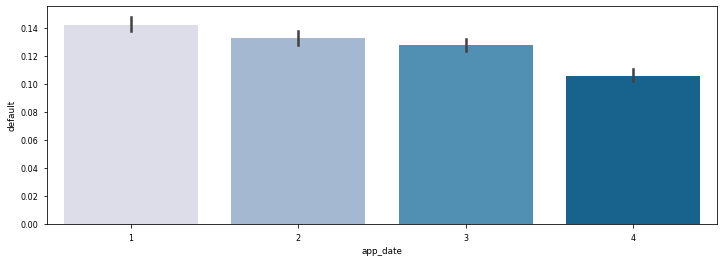

In [28]:
# Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки
plt.style.use('seaborn-paper')
plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')(0.85)
sns.barplot(data=df[df['sample']==1], x=df.loc[df['sample']==1,'app_date'].dt.month, y='default', palette="PuBu");

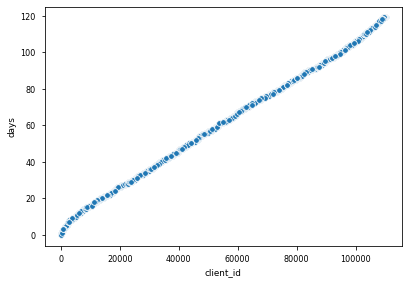

In [29]:
# Выясняем, что в банке велась сквозная нумерация клиентов в зависимости от дня обращения
sns.scatterplot(x='client_id',y='days',data=df)

### Посмотрим корреляцию признаков

In [41]:

corr_matrix = pd.concat([df[numeric_cols], df.default], axis=1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "10pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "10pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '10pt')])
]

corr_matrix.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,age,decline_app_cnt,score_bki,bki_request_cnt,income,default
age,1.00,-0.11,-0.10,0.05,-0.02,-0.03
decline_app_cnt,-0.11,1.00,0.19,0.16,-0.02,0.11
score_bki,-0.10,0.19,1.00,0.16,-0.01,0.18
bki_request_cnt,0.05,0.16,0.16,1.00,0.08,0.08
income,-0.02,-0.02,-0.01,0.08,1.00,-0.04
default,-0.03,0.11,0.18,0.08,-0.04,1.00


In [42]:
print('Ранг матрицы - {}, det(corr_mat) = {}'.format(np.linalg.matrix_rank(corr_matrix), np.linalg.det(corr_matrix)))
corr_matrix.shape

Ранг матрицы - 6, det(corr_mat) = 0.855664653382397


(6, 6)

Ранг матрицы корреляций максимальный, определитель близок к единице. Между признаками связь слабая, коэффициент корреляции менее 0.1. 

Кроме количества отмененных заявок и запросов в БКИ - между ними коэффициент 0.18.

### Оценка значимости числовых переменных.
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn. 

Возможности модуля sklearn.feature_selection могут быть использованы не только для выбора важных признаков, но и для уменьшения размерности, улучшения предсказательной силы моделей, либо для повышения их производительности на очень многомерных наборах данных.
****
В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

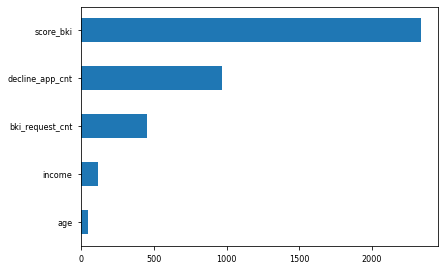

In [46]:
imp_num = pd.Series(f_classif(df_train[numeric_cols], df_train['default'])[0], index = numeric_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Мы сделали визуализацию распределения важности признаков и видим, что оценка плательщика БКИ (score_bki) самый значимый показатель по ANOVA F test, потом количество отмененных заявок (decline_app_cnt) и в конце возраст (age)

### Посмотрим на значимость категориальных и бинарных переменных 
#### Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [53]:
# Для начала преобразуем данные: для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in binary_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,age_log,decline_app_cnt_log,score_bki_log,bki_request_cnt_log,income_log,days
0,74835,80,1,1,29,1,1,0,0,-2.271884,3,3,0,1,50000,0,3,0,0,NaN,3.367296,0.000000,0.0,1.098612,10.819778,80
1,17527,23,3,0,39,0,0,5,0,-1.504999,2,3,0,1,5000,3,2,0,0,NaN,3.663562,1.609438,0.0,0.693147,8.517193,23
2,75683,81,4,1,50,1,1,0,0,-1.691339,1,3,0,1,30000,0,2,1,0,NaN,3.912023,0.000000,0.0,0.000000,10.308953,81
3,26883,33,3,1,56,0,0,0,0,-2.374182,1,2,0,1,17000,0,2,0,0,NaN,4.025352,0.000000,0.0,0.000000,9.740969,33
4,28862,34,1,0,38,0,0,0,0,-2.487502,0,6,1,2,120000,0,2,0,0,NaN,3.637586,0.000000,0.0,0.000000,11.695247,34


In [59]:
# Для категориальных признаков применим метод кодирования One-Hot Encoding:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[category_cols].values)

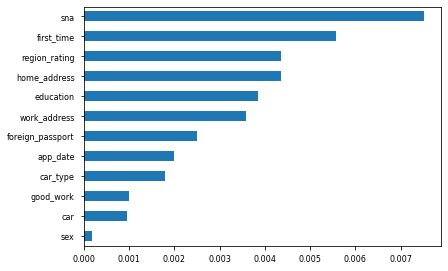

In [58]:
imp_cat = pd.Series(mutual_info_classif(df[df['sample']==1][binary_cols + category_cols], df[df['sample']==1]['default'],
                                     discrete_features =True), index = binary_cols + category_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Таким образом, самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time), потом идет рейтинг региона (region_rating) и в конце пол (sex).

## Подготовка данных к машинному обучению

In [61]:
# Стандартизируем числовые переменные:
X_num = StandardScaler().fit_transform(df[numeric_cols + numeric_log].values)

# Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные 
# в одно признаковое пространство, разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, df[binary_cols].values, X_cat])
Y = df['default'].values

### Удаление лишних критериев

In [62]:
print(numeric_cols)
print(numeric_log)

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
['age_log', 'decline_app_cnt_log', 'score_bki_log', 'bki_request_cnt_log', 'income_log']


In [63]:
df.drop(['app_date', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki_log'], axis=1, inplace=True)

### Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [80]:
# зафиксируем версию пакетов и RANDOM_SEED, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 42

# на всякий случай, заново подгружаем данные

DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

#Заранее сохраняем значения client_id для предсказания тестовой выборки
id_test = df_test['client_id']

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

# объединяем
df = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [47]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [48]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0


In [70]:
# ну и функции отдельно
# Функция по созданию нового признака:


def creating_new_columns(df, column, function):
    if function == 'log':
        df[df[column].name+'_log'] = np.log(df[column][df[column] > 0])
        df[df[column].name+'_log'].fillna(0, inplace=True)
    elif function=='sqrt':
        df[df[column].name+'_sqrt'] = np.sqrt(df[column][df[column] > 0])
        df[df[column].name+'_sqrt'].fillna(0, inplace=True)
    elif function =='isNAN':
        if df[column].isnull().any() == True:
            df[df[column].name+'_isNAN'] = pd.isna(df[column]).astype('uint8')


In [88]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка #################################################

    # Заполним пропуски в образовании самым распространенным значением SCH
    df_output.education.fillna('SCH', inplace=True)

    # Распределим признаки (за исключением client_id, default и sample) по категориям: бинарные, категориальные и числовые
    cols = df_output.columns[1:-2]
    binary_cols, category_cols, numeric_cols = [], [], []
    for j in cols:
        if len(df_output[j].value_counts(dropna=False))==2:
            binary_cols.append(j)
        elif len(df_output[j].value_counts(dropna=False))<11 or df_output[j].dtypes==object:
            category_cols.append(j)
        else:
            numeric_cols.append(j)


    # Для каждого числового признака создам новый признак, содержащий логарифмированную величину этой переменной
    numeric_log, func = [], 'log'

    for i in numeric_cols:
        creating_new_columns(df_output, i, func)
        numeric_log.append(i+'_'+func)
    
    # Для каждого числового признака создам новый признак, содержащий корень величины этой переменной
    numeric_sqrt, func = [], 'sqrt'

    for i in numeric_cols:
        creating_new_columns(df_output, i, func)
        numeric_sqrt.append(i+'_'+func)
    
    # Преобразуем формат признака даты
    df_output.app_date = pd.to_datetime(df_output.app_date, format='%d%b%Y')
    
    # Вводим новый признак - номер дня с 1 января
    start = df_output.app_date.min()
    #end = df_output.app_date.max()
    df_output['days'] = (df_output.app_date - start).dt.days.astype('int')
    
    # Добавим еще несколько новых признаков
    today = datetime.now()
    df_output['days_passed'] = (today - df_output.app_date).dt.days
    df_output['app_date_month'] = df_output['app_date'].dt.month
    df_output['app_date_day'] = df_output['app_date'].dt.day
    df_output['app_date_interval'] = df_output['app_date_day'].apply(lambda x: 1 if 8 < x < 22 else 0)
    df_output['app_date_of_week'] = df_output['app_date'].dt.dayofweek
    
    # Запишем все новые признаки от app_date в список:
    date_cols = ['days', 'days_passed', 'app_date_month', 'app_date_day', 'app_date_interval', 'app_date_of_week']
    
    # Удалим лишние признаки:
    df_output.drop(['app_date', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki_log'], axis=1, inplace=True)
    
    # Перераспределим признаки (за исключением client_id, default и sample) по категориям: бинарные, категориальные и числовые
    binary_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
    category_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
    numeric_cols = ['score_bki', 'age_log', 'decline_app_cnt_log', 'bki_request_cnt_log', 'income_log', 
                    'age_sqrt', 'decline_app_cnt_sqrt', 'score_bki_sqrt', 'bki_request_cnt_sqrt', 'income_sqrt']
    
    # Будем запускать отдельно для train и отдельно для test, поэтому удалим 'sample', 'client_id'
    df_output.drop(['sample', 'client_id'], axis=1, inplace=True)
    
    # Преобразуем данные: 
    # для бинарных признаков мы будем использовать LabelEncoder
    label_encoder = LabelEncoder()

    for column in binary_cols:
        df_output[column] = label_encoder.fit_transform(df_output[column].values)
    
    # Для категориальных признаков применим метод кодирования One-Hot Encoding:
    X_cat = OneHotEncoder(sparse = False).fit_transform(df_output[category_cols].values)

    # Стандартизируем числовые переменные:
    X_num = StandardScaler().fit_transform(df_output[numeric_cols+date_cols].values)

    # Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные 
    # в одно признаковое пространство, разделив при этом признаки и целевую переменную.
    if 'default' in df_output.columns:
        Y = df_output['default'].values
        df_output.drop(['default'], axis=1, inplace=True)
        df_output = np.hstack([X_num, df_output[binary_cols].values, X_cat])
        return df_output, Y
    else:
        df_output = np.hstack([X_num, df_output[binary_cols].values, X_cat])
        return df_output
    

        
    #return df_output



## Построение модели
---
### Разбиваем датасет на тренировочный и тестовый

In [89]:
# Разбиваем датасет на тренировочный и тестовый:
# train_data = df_preproc_train.drop(['sample', 'client_id'], axis=1)
# test_data = df_preproc_test.drop(['sample', 'client_id'], axis=1)

# y = train_data.default.values
# X = train_data.drop(['default'], axis=1)

# Запускаем отдельно для train и для test. Проверяем, что получилось:
train_data, y = preproc_data(df_train)
test_data = preproc_data(df_test)
print(train_data.shape, test_data.shape)

X = train_data
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape


(73799, 47) (36349, 47)


((36349, 47), (73799, 47), (73799, 47), (59039, 47), (14760, 47))

### Обучаем модель, генерируем результат и сравниваем с тестом

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


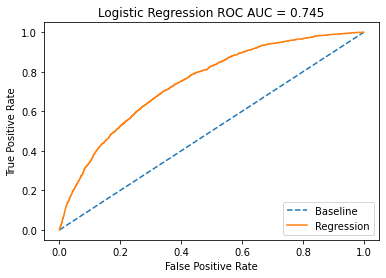

In [90]:
# Обучим модель на стандартных настройках логистической регрессии.
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

# Напишем код для построения ROC AUС
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


# y_pred = model.predict(X_test)
# f1_test = f1_score(y_test, y_pred)
# print(f1_test)

## Регуляризация. Подбор параметров

In [91]:
model = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=500, random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))
print('ROC AUC: %.4f' % roc_auc_score(y_test, preds))

	C: 1
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6705
Precision: 0.2267
Recall: 0.6891
F1: 0.3411
ROC AUC: 0.6785


In [75]:
# вторая модель на параметрах после первой оптимизации
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l2', 
                           solver = 'sag', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print('ROC AUC: %.4f' % roc_auc_score(y_test, y_pred_prob)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Результат

In [92]:
X_train=train_data
y_train = y
X_test = test_data

# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape


((36349, 47), (73799, 47), (73799, 47), (73799,), (36349, 47))

In [93]:

model = LogisticRegression(C=1, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter=1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)
submit